One of the two most important notebooks of the project. This notebook covers both calculating photoemtry data from the Herschel .fits files, generating images from those .fits file, as well as generate individual galaxies HTML files that contains these images amongst other data.

The photometry part of the program is attached alongside the generating images part because during troubleshooting this was the easiest. But because the image generation section takes by far the most time, feel free to comment the sections out in order to run photometry more quickly.

There is also an unfinished profile graphing code block in progress. The idea is to calculate both the flux change from ellipse to ellipse of these galaxies, as well as the total flux as you get to bigger and bigger ellipses. And then graph both of these for all galaxies onto a postage stamp of 4-6 plots.

And finally the HTML generation outputs the galaxies and link them together ordered by their VFID.

The first 2 blocks are to import the necessary packages.

In [1]:
#Importing most necessary libraries

from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
import os
import numpy as np
from astropy.io.ascii import masked
from astropy.coordinates import Angle
from astropy.io import ascii
import glob
from astropy.io import fits
import wget
import matplotlib.image as mpimg
from astropy.wcs import WCS
from scipy.stats import scoreatpercentile
from astropy.visualization import simple_norm
from reproject import reproject_interp
import sys
from IPython.display import clear_output
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import ImageNormalize
from astropy.visualization import LogStretch
from astropy.wcs import WCS
import astropy.units as u
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import Angle
from scipy import stats
from astropy.visualization import MinMaxInterval
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.stats import gaussian_sigma_to_fwhm

from astropy.nddata import CCDData
import warnings
warnings.filterwarnings('ignore')

mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

#define an empty dictionary that will contain the EllipseGeometry instance
geometry = {}
initparams = {}
#initialize dictionary for half-light radii
rhalfpix = {}
rhalfasec = {}
from photutils.isophote import Ellipse
from photutils import aperture_photometry
#initialize dictionary for ellipse fitting
ellipse = {}
isolist = {}
#Set the home path
os.environ['HOME'] ='C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir+'/Virgo/tables' #set to where to get the tables
plotdir = homedir+'/Virgo/plots' #set to where the plots should go
datadir = homedir+'/HTML-building/galaxy' #set to where the html resources should be (parent folder of the different html folders)
maskdir = homedir+'/masking/' #set to where the completed mask fits are

In [2]:
from photometry_funct import *

This is the code to both calculate the photometry AND generating .png files to visualize the galaxies. I do think it's probably best to separate them, but I never managed to get around to it. The code reads in the photometry table's data regarding namely galaxy, RA, DEC, as well as their ellipse data namely BA, PA, and SMA. The program does do photometry over all 8 SMA values, so it calculates the Herschel photometry 8 times for each image.

Because Herschel's naming isn't straightforward, I find individual files inside the code itself, and then perform photometry on them using photutils. To disable the image generation comment out both the v1 and v2 calculations, as well as the imdisplay2 functions. There are these bits out code for every band, so you'll need to comment out 3 times.

Image intensity limits: v1=5.643724070978631e-07, v2=0.0031125775687808237
NGC4589 70µm SMA1: 0.07697960364226959, Good Pixels: 1.00%
NGC4589 70µm SMA2: 0.18769598759402364, Good Pixels: 1.00%
NGC4589 70µm SMA3: 0.2448966229241275, Good Pixels: 1.00%
NGC4589 70µm SMA4: 0.2842970295622842, Good Pixels: 1.00%
NGC4589 70µm SMA5: 0.3177040383629487, Good Pixels: 1.00%
NGC4589 70µm SMA6: 0.35561182881349246, Good Pixels: 1.00%
NGC4589 70µm SMA7: 0.4020932510180405, Good Pixels: 0.99%
NGC4589 70µm SMA8: 0.45298834664748516, Good Pixels: 0.97%
Image intensity limits: v1=2.21401137423522e-07, v2=0.00657667959547661
NGC4589 100µm SMA1: 0.11075042775720871, Good Pixels: 1.00%
NGC4589 100µm SMA2: 0.30413251419245213, Good Pixels: 1.00%
NGC4589 100µm SMA3: 0.4165176215630557, Good Pixels: 1.00%
NGC4589 100µm SMA4: 0.4744408963695129, Good Pixels: 1.00%
NGC4589 100µm SMA5: 0.5248284029587778, Good Pixels: 1.00%
NGC4589 100µm SMA6: 0.5836720572326519, Good Pixels: 1.00%
NGC4589 100µm SMA7: 0.6434749

KeyboardInterrupt: 

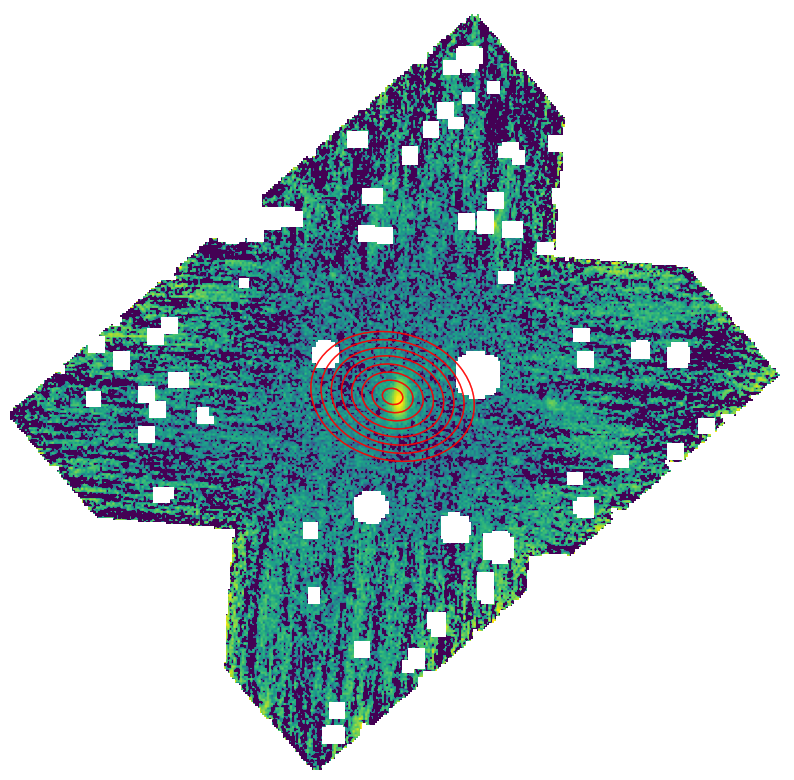

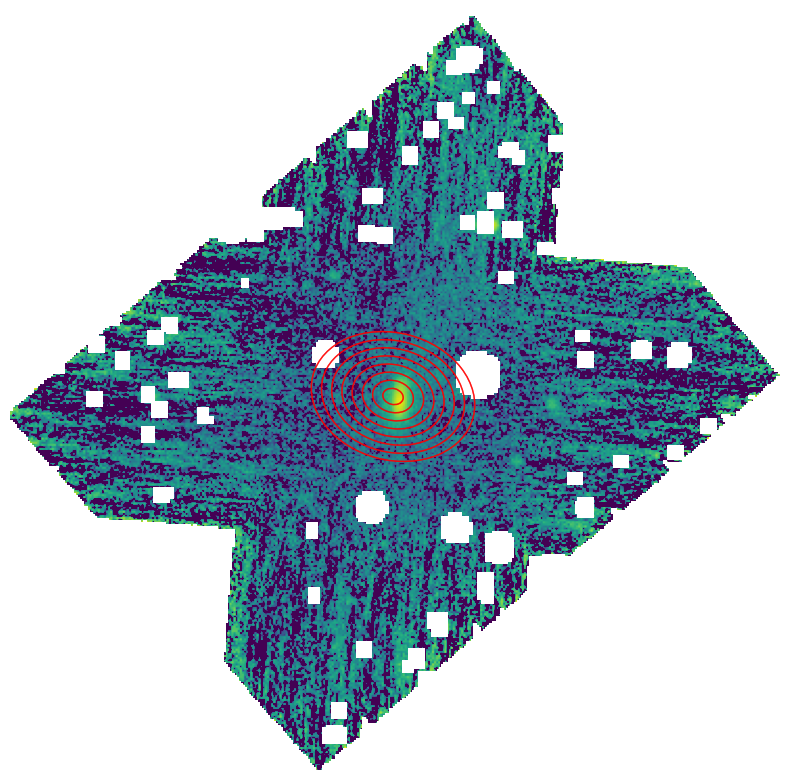

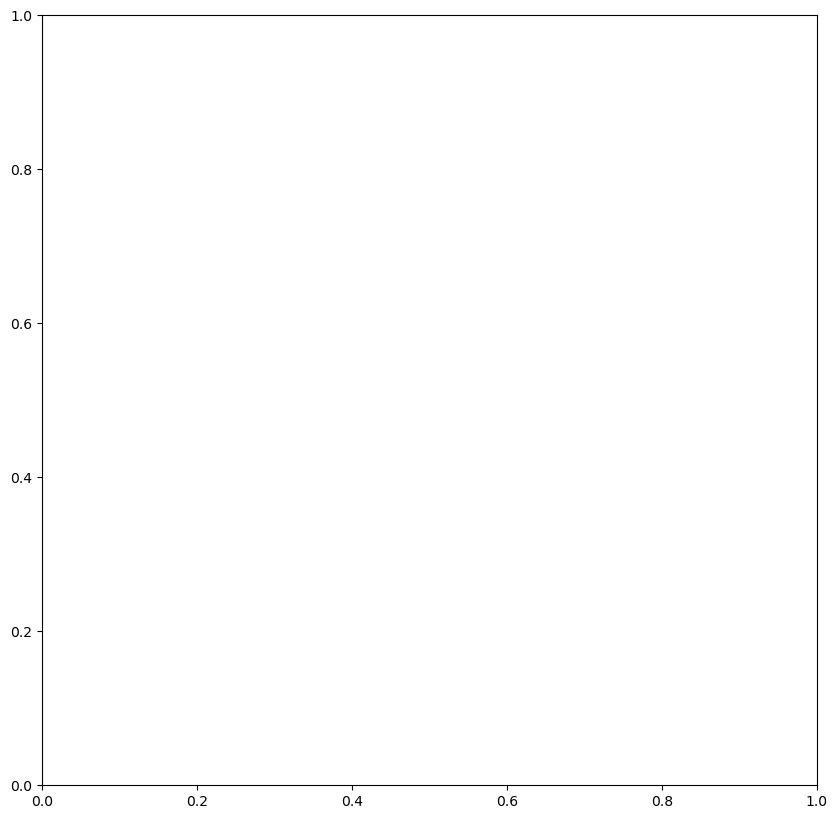

In [3]:
#calclating the photometry and generating ellipse images (masked)
#ellipse generation for the herschel matches
csv_file = tabledir+'/Photometrytesting.csv'
csv_file2 = tabledir+'/Herschelstuff.csv'
galaxy = Table.read(csv_file)
galaxy2 = Table.read(csv_file2)
sma_labels = [f"SMA_AP0{i}" for i in range(1, 9)]
flux_labels = [f"{wave}Flux_{sma}" for wave in (70, 100, 160) for sma in sma_labels]
good_pixel_labels = [f"{wave}GoodPixels_{sma}" for wave in (70, 100, 160) for sma in sma_labels]
galaxy_length = len(galaxy)
# Initialize new columns in the galaxy table
for label in flux_labels:
    galaxy[label] = np.zeros(len(galaxy))
for label2 in good_pixel_labels:
    galaxy[label2] = np.zeros(len(galaxy))
for i in range(galaxy_length):
    galaxy_name = str(galaxy['GALAXY'][i])
    RA = galaxy['RA_MOMENT'][i]
    DEC = galaxy['DEC_MOMENT'][i]
    EPLI = galaxy['BA_MOMENT'][i]
    PAN = (galaxy['PA_MOMENT'][i] + 90) * np.pi / 180
    path = datadir + '/pipeline/' + galaxy_name
    VFID = f"VFID{int(galaxy['VF_ID'][i]):04d}"
    if os.path.exists(path):
        ## Masked files directory
        if os.path.exists(maskdir + '/masked/'+ galaxy_name+ '_maskedB.fits') == True:
            found_files = os.path.join(maskdir, 'masked', f'{galaxy_name}_maskedB.fits')
            placeholder = fits.open(found_files)
        else:
            destination_folder = path + '\\HPPUNIMAPB'
            partial_name = 'hpacs_25HPPUNIMAPB'
            found_files = find_files(destination_folder, partial_name)
            if found_files:
            #For properly reading only one unmasked file
                found_file = found_files[0]
                placeholder = fits.open(found_file)
        if found_files:
            #For properly reading only one unmasked file
            #found_file = found_files[0]
            #placeholder = fits.open(found_file)
            #For reading the masked image (also change the data, header section appropriately)
            pixscale = 1.60000001784
            wave = str(70)  # Convert to string for column naming
            data, header = fits.getdata(found_files, header=True)
            wcs = WCS(header)

            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {'xcen': x0, 'ycen': y0, 'ellip': EPLI, 'PA': PAN}
            
            fig, ax = plt.subplots(figsize=(10, 10))
            nimage = np.array(data)

            # Calculate v1 and v2 dynamically (COMMENT OUT TO CUT DOWN RUN TIME)
            v1, v2 = None, None
            for v1perc in np.arange(0.1, 40.0, 0.1):
                v1 = scoreatpercentile(nimage, v1perc)
                if v1 > 0:
                    break
            for v2perc in np.arange(99.9, 20.0, -0.1):
                v2 = scoreatpercentile(nimage, v2perc)
                if not np.isnan(v2):
                    break
            sma_values = [(galaxy[sma_label][i] * 0.262) / pixscale for sma_label in sma_labels]  # Convert SMA values
            max_sma = max(sma_values)  # Get the largest converted SMA value
            ellipses = [(x0, y0, sma, EPLI, PAN) for sma in sma_values]  # Create ellipse list
            imdisplay2(data, ellipses, v1perc, v2perc, logscale=True) #COMMENT THIS OUT TO DISABLE IMAGE DISPLAY
            # Loop over all SMA values to compute flux and overlay ellipses
            for j, sma_label in enumerate(sma_labels):
                SMAO = galaxy[sma_label][i]
                SMAN = (SMAO * 0.262) / pixscale
                initparams[galaxy_name][f'sma_{j+1}'] = SMAN
                geometry[galaxy_name] = EllipseGeometry(
                    x0=x0, y0=y0, sma=SMAN, eps=EPLI, pa=PAN
                )
                # Create elliptical aperture
                aper = EllipticalAperture(
                    (geometry[galaxy_name].x0, geometry[galaxy_name].y0),
                    geometry[galaxy_name].sma,
                    geometry[galaxy_name].sma * (geometry[galaxy_name].eps),
                    geometry[galaxy_name].pa
                )
                 # Mask calculation based on NaN values (masked pixels are NaN)
                aperture_mask = aper.to_mask(method='center')
                aperture_data = aperture_mask.multiply(nimage)  # Extract the region within the aperture

                # Count total pixels within the aperture
                total_pixels = np.isfinite(aperture_data).sum()  # Total pixels that are not NaN
                empty_pixels = np.isnan(aperture_data).sum()  # Already masked pixels (NaN values)
            
                # Calculate the percentage of masked (NaN) pixels
                if total_pixels + empty_pixels > 0:
                    good_percentage = 1 - (empty_pixels / (total_pixels + empty_pixels))
                else:
                    good_percentage = 1  # If no pixels are counted, default to 0 

                # Replace NaN values with 0 in the whole image before photometry
                data_nonan = np.nan_to_num(nimage, nan=0)
                # Perform aperture photometry
                phot_table = aperture_photometry(data_nonan, aper)
                flux_value = phot_table['aperture_sum'][0]
                # Store flux in the corresponding column
                galaxy[f"{wave}Flux_{sma_label}"][i] = flux_value
                galaxy[f"{wave}GoodPixels_{sma_label}"][i] = good_percentage
                print(f"{galaxy_name} {wave}µm SMA{j+1}: {flux_value}, Good Pixels: {good_percentage:.2f}%")

                # Overlay ellipse onto the image
                aper.plot(color='red', lw=1, alpha=0.7)

            plt.subplots_adjust(wspace=0, hspace=0)
            #For unmasked postage stamps
            #plt.savefig(datadir + f'/photometry/{VFID}-{galaxy_name}-{wave}-AP.png', dpi=150)
            #For masked postage stamps
            plt.savefig(datadir + f'/mask/{VFID}-{galaxy_name}-{wave}-AP.png', dpi=150)
            plt.close(fig)
        ## Masked files directory
        if os.path.exists(maskdir + '/masked/'+ galaxy_name+ '_maskedG.fits')  == True:
            found_files = os.path.join(maskdir, 'masked', f'{galaxy_name}_maskedG.fits')
            placeholder = fits.open(found_files)
        else:
            destination_folder = path + '\\HPPUNIMAPG'
            partial_name = 'hpacs_25HPPUNIMAPB'
            found_files = find_files(destination_folder, partial_name)
            if found_files:
            #For properly reading only one unmasked file
                found_file = found_files[0]
                placeholder = fits.open(found_file)
        if found_files:
            #For properly reading only one unmasked file
            #found_file = found_files[0]
            #placeholder = fits.open(found_file)
            #For reading the masked image (also change the data, header section appropriately)
            pixscale = 1.60000001784
            wave = str(100)  # Convert to string for column naming
            data, header = fits.getdata(found_files, header=True)
            wcs = WCS(header)

            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {'xcen': x0, 'ycen': y0, 'ellip': EPLI, 'PA': PAN}
            
            fig, ax = plt.subplots(figsize=(10, 10))
            nimage = np.array(data)

            # Calculate v1 and v2 dynamically (COMMENT OUT TO CUT DOWN RUN TIME)
            v1, v2 = None, None
            for v1perc in np.arange(0.1, 40.0, 0.1):
                v1 = scoreatpercentile(nimage, v1perc)
                if v1 > 0:
                    break
            for v2perc in np.arange(99.9, 20.0, -0.1):
                v2 = scoreatpercentile(nimage, v2perc)
                if not np.isnan(v2):
                    break
            sma_values = [(galaxy[sma_label][i] * 0.262) / pixscale for sma_label in sma_labels]  # Convert SMA values
            max_sma = max(sma_values)  # Get the largest converted SMA value
            ellipses = [(x0, y0, sma, EPLI, PAN) for sma in sma_values]  # Create ellipse list
            imdisplay2(data, ellipses, v1perc, v2perc, logscale=True) # COMMENT OUT TO DISABLE IMAGE DISPLAY
            # Loop over all SMA values to compute flux and overlay ellipses
            for j, sma_label in enumerate(sma_labels):
                SMAO = galaxy[sma_label][i]
                SMAN = (SMAO * 0.262) / pixscale
                initparams[galaxy_name][f'sma_{j+1}'] = SMAN
                geometry[galaxy_name] = EllipseGeometry(
                    x0=x0, y0=y0, sma=SMAN, eps=EPLI, pa=PAN
                )
                # Create elliptical aperture
                aper = EllipticalAperture(
                    (geometry[galaxy_name].x0, geometry[galaxy_name].y0),
                    geometry[galaxy_name].sma,
                    geometry[galaxy_name].sma * (geometry[galaxy_name].eps),
                    geometry[galaxy_name].pa
                )
                aperture_mask = aper.to_mask(method='center')
                aperture_data = aperture_mask.multiply(nimage)  # Extract the region within the aperture

                # Count total pixels within the aperture
                total_pixels = np.isfinite(aperture_data).sum()  # Total pixels that are not NaN
                empty_pixels = np.isnan(aperture_data).sum()  # Already masked pixels (NaN values)
            
                # Calculate the percentage of masked (NaN) pixels
                if total_pixels + empty_pixels > 0:
                    good_percentage = 1 - (empty_pixels / (total_pixels + empty_pixels))
                else:
                    good_percentage = 1  # If no pixels are counted, default to 0 

                # Replace NaN values with 0 in the whole image before photometry
                data_nonan = np.nan_to_num(nimage, nan=0)
                # Perform aperture photometry
                phot_table = aperture_photometry(data_nonan, aper)
                flux_value = phot_table['aperture_sum'][0]
                # Store flux in the corresponding column
                galaxy[f"{wave}Flux_{sma_label}"][i] = flux_value
                galaxy[f"{wave}GoodPixels_{sma_label}"][i] = good_percentage
                print(f"{galaxy_name} {wave}µm SMA{j+1}: {flux_value}, Good Pixels: {good_percentage:.2f}%")

                # Overlay ellipse onto the image
                aper.plot(color='red', lw=1, alpha=0.7)

            plt.subplots_adjust(wspace=0, hspace=0)
            #For unmasked postage stamps
            #plt.savefig(datadir + f'/photometry/{VFID}-{galaxy_name}-{wave}-AP.png', dpi=150)
            #For masked postage stamps
            plt.savefig(datadir + f'/mask/{VFID}-{galaxy_name}-{wave}-AP.png', dpi=150)
            plt.close(fig)
        ## Masked files directory
        if os.path.exists(maskdir + '/masked/'+ galaxy_name+ '_maskedR.fits')  == True:
            found_files = os.path.join(maskdir, 'masked', f'{galaxy_name}_maskedR.fits')
            placeholder = fits.open(found_files)
        else:
            destination_folder = path + '\\HPPUNIMAPR'
            partial_name = 'hpacs_25HPPUNIMAPR'
            found_files = find_files(destination_folder, partial_name)
            if found_files:
            #For properly reading only one unmasked file
                found_file = found_files[0]
                placeholder = fits.open(found_file)
        if found_files:
            #For properly reading only one unmasked file
            #found_file = found_files[0]
            #placeholder = fits.open(found_file)
            #For reading the masked image (also change the data, header section appropriately)
            pixscale = 3.20000003568
            wave = str(160)  # Convert to string for column naming
            data, header = fits.getdata(found_files, header=True)
            wcs = WCS(header)

            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {'xcen': x0, 'ycen': y0, 'ellip': EPLI, 'PA': PAN}
            
            fig, ax = plt.subplots(figsize=(10, 10))
            nimage = np.array(data)

            # Calculate v1 and v2 dynamically
            v1, v2 = None, None
            for v1perc in np.arange(0.1, 40.0, 0.1): #(COMMENT OUT TO CUT DOWN RUN TIME)
                v1 = scoreatpercentile(nimage, v1perc)
                if v1 > 0:
                    break
            for v2perc in np.arange(99.9, 20.0, -0.1):
                v2 = scoreatpercentile(nimage, v2perc)
                if not np.isnan(v2):
                    break
            sma_values = [(galaxy[sma_label][i] * 0.262) / pixscale for sma_label in sma_labels]  # Convert SMA values
            max_sma = max(sma_values)  # Get the largest converted SMA value
            ellipses = [(x0, y0, sma, EPLI, PAN) for sma in sma_values]  # Create ellipse list
            imdisplay2(data, ellipses, v1perc, v2perc, logscale=True) #COMMENT OUT TO DISABLE IMAGE DISPLAY
            # Loop over all SMA values to compute flux and overlay ellipses
            for j, sma_label in enumerate(sma_labels):
                SMAO = galaxy[sma_label][i]
                SMAN = (SMAO * 0.262) / pixscale
                initparams[galaxy_name][f'sma_{j+1}'] = SMAN
                geometry[galaxy_name] = EllipseGeometry(
                    x0=x0, y0=y0, sma=SMAN, eps=EPLI, pa=PAN
                )
                # Create elliptical aperture
                aper = EllipticalAperture(
                    (geometry[galaxy_name].x0, geometry[galaxy_name].y0),
                    geometry[galaxy_name].sma,
                    geometry[galaxy_name].sma * (geometry[galaxy_name].eps),
                    geometry[galaxy_name].pa
                )
                aperture_mask = aper.to_mask(method='center')
                aperture_data = aperture_mask.multiply(nimage)  # Extract the region within the aperture

                # Count total pixels within the aperture
                total_pixels = np.isfinite(aperture_data).sum()  # Total pixels that are not NaN
                empty_pixels = np.isnan(aperture_data).sum()  # Already masked pixels (NaN values)
                # Calculate the percentage of masked (NaN) pixels
                if total_pixels + empty_pixels > 0:
                    good_percentage = 1 - (empty_pixels / total_pixels)
                else:
                    good_percentage = 1  # If no pixels are counted, default to 0 
                # Replace NaN values with 0 in the whole image before photometry
                data_nonan = np.nan_to_num(nimage, nan=0)
                # Perform aperture photometry
                phot_table = aperture_photometry(data_nonan, aper)
                flux_value = phot_table['aperture_sum'][0]
                # Store flux in the corresponding column
                galaxy[f"{wave}Flux_{sma_label}"][i] = flux_value
                galaxy[f"{wave}GoodPixels_{sma_label}"][i] = good_percentage
                print(f"{galaxy_name} {VFID} {wave}µm SMA{j+1}: {flux_value}, Good Pixels: {good_percentage:.2f}%")

                # Overlay ellipse onto the image
                aper.plot(color='red', lw=1, alpha=0.7)

            plt.subplots_adjust(wspace=0, hspace=0)
            #For unmasked postage stamps
            #plt.savefig(datadir + f'/photometry/{VFID}-{galaxy_name}-{wave}-AP.png', dpi=150)
            #For masked postage stamps
            plt.savefig(datadir + f'/mask/{VFID}-{galaxy_name}-{wave}-AP.png', dpi=150)
            plt.close(fig)
galaxy.write(tabledir+'/Photometrytesting2.csv', format='csv', overwrite=True)
print('done')
plt.close(fig)

This is the unfinished profile graphing code block. The desired output is a series of 4 or 6 plots depending on how many bands of Herschel does a particular galaxy has. Where one set of plot is the graph of the number ellipse vs total flux in that ellipse of a given galaxy in a given band. While the other set of plot should plot the number of ellipse vs the difference in flux of the respective ellipses (effectively the rate of change).

I was having trouble with setting up the rate of change correctly.

In [ ]:
#profile graphing (UNFINISHED)
# Load the photometry data
csv_file = tabledir + '/Photometrytesting2.csv'
galaxy = Table.read(csv_file)

# Define semi-major axis (SMA) and flux labels
sma_labels = [f"SMA_AP0{i}" for i in range(1, 9)]
wavelengths = [70, 100, 160]
colors = ['blue', 'green', 'red']  # Corresponding colors for wavelengths

# Loop over each galaxy
for i in range(len(galaxy)):
    galaxy_name = str(galaxy['GALAXY'][i])
    VFID = f"VFID{int(galaxy['VF_ID'][i]):04d}"
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
    
    for j, wave in enumerate(wavelengths):
        sma_values = []
        sma_values_2 = []
        flux_values = []
        sb_values = []  # Surface brightness values (difference in flux)

        for k in range(len(sma_labels) - 1):  # Need at least two points for SB calculation
            sma_label_1 = sma_labels[k]
            sma_label_2 = sma_labels[k + 1]
            flux_col_1 = f"{wave}Flux_{sma_label_1}"
            flux_col_2 = f"{wave}Flux_{sma_label_2}"
            if flux_col_1 in galaxy.colnames and flux_col_2 in galaxy.colnames:
                flux_1 = galaxy[flux_col_1][i]
                flux_2 = galaxy[flux_col_2][i]
                sma_pixels_1 = galaxy[sma_label_1][i]
                sma_pixels_2 = galaxy[sma_label_2][i]
                sma_arcsec_1 = sma_pixels_1 * 0.262  # Convert to arcseconds
                sma_arcsec_2 = sma_pixels_2 * 0.262

                if not np.isnan(flux_1) and not np.isnan(flux_2) and flux_1 > 0 and flux_2 > 0:
                    sma_values.append(sma_arcsec_1)
                    sma_values_2.append(sma_arcsec_1)
                    if colors[j] == 'blue' or colors[j] == 'green':
                        flux_1 = flux_1 * 1.60000001784
                    else:
                        flux_1 = flux_1 * 3.20000003568
                    flux_values.append(flux_1)

                    # Compute surface brightness: ΔFlux / (π * (r2² - r1²))
                    area_annulus = np.pi * (sma_arcsec_2**2 - sma_arcsec_1**2)
                    if area_annulus > 0:
                        sb_values.append((flux_2 - flux_1) / area_annulus)
                    else:
                        sb_values.append(0)  # Avoid division by zero
            if sma_label_2 == 'SMA_AP08':
                sma_values_2.append(sma_arcsec_2)
                if colors[j] == 'blue' or colors[j] == 'green':
                    flux_2 = flux_2 * 1.60000001784
                else:
                    flux_2 = flux_2 * 3.20000003568
                flux_values.append(flux_2)

        # Plot Flux Profile
        if sma_values:
            axes[0, j].plot(sma_values_2, flux_values, marker='o', label=f"{wave} µm", color=colors[j])
            axes[0, j].set_title(f"{wave} µm Flux Profile")
            axes[0, j].set_xlabel("Semi-Major Axis (arcsec)")
            axes[0, j].set_ylabel("Flux (Jy/arcsec)")
            axes[0, j].legend()

        # Plot Surface Brightness Profile
        if sma_values and len(sb_values) > 0:
            axes[1, j].plot(sma_values, sb_values, marker='s', color=colors[j])
            axes[1, j].set_title(f"{wave} µm Surface Brightness")
            axes[1, j].set_xlabel("Semi-Major Axis (arcsec)")
            axes[1, j].set_ylabel("Surface Brightness")

    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    output_path = f"{datadir}/profiles/{VFID}-{galaxy_name}_flux_sb_profile.png"
    plt.savefig(output_path, dpi=150)
    plt.close()

print("All flux and surface brightness profiles generated.")

This is the code to write out individual HTML files for the galaxies. These can be accessed using the link in the HTML website generation notebook.

In [ ]:
#individual html writing
galaxy = Table.read(tabledir+'/Photometrytesting2.csv')
for i in range(len(galaxy)):
    # Check bounds for i+1
    if i + 1 < len(galaxy):
        galaxy_name2 = str(galaxy['GALAXY'][i + 1])
        VFID2 = f"VFID{int(galaxy['VF_ID'][i + 1]):04d}"
    else:
        galaxy_name2 = '0'
        VFID2 = '0'

    # Check bounds for i-1
    if i - 1 >= 0:
        galaxy_name3 = str(galaxy['GALAXY'][i - 1])
        VFID3 = f"VFID{int(galaxy['VF_ID'][i - 1]):04d}"
    else:
        galaxy_name3 = '0'
        VFID3 = '0'
    galaxy_name = str(galaxy['GALAXY'][i])
    path = datadir + '\\pipeline\\' + galaxy_name
    VFID = f"VFID{int(galaxy['VF_ID'][i]):04d}"
    RA = str(galaxy['RA_MOMENT'][i])
    DEC = str(galaxy['DEC_MOMENT'][i])
    filepath = datadir+'/html/'+VFID+'-'+galaxy_name+'.html'
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    # Write the HTML code line by line
    with open(filepath, "w") as html:
        html.write('<html><body>\n')
        html.write('<h1>'+VFID+'</h1>')
        if VFID3 == '0':
            html.write('<a href="'+homedir+'/HTML-building/output.html">Home</a>')
            html.write('<br />')
        else:
            html.write('<a href="'+VFID3+'-'+galaxy_name3+'.html">Previous'+VFID3+'</a>')
            html.write('<br />')
        if VFID2 == '0':
            html.write('<a href="'+homedir+'/HTML-building/output.html">Home</a>')
            html.write('<br />')
        else:
            html.write('<a href="'+VFID2+'-'+galaxy_name2+'.html">Next'+VFID2+'</a>')
            html.write('<br />')
        html.write('<h2>Photometry data</h2>\n')
        html.write('<style type="text/css">\n')
        html.write('table, td, th {padding: 5px; text-align: center; border: 2px solid black;}\n')
        html.write('p {display: inline-block;;}\n')
        html.write('</style>\n')
        html.write('<table width="100%"><tr><th>VFID</th><th>Name</th><th>Legacy image</th><th>Herschel-UnimapBlue (70microns)</th><th>Herschel-UnimapBlue (100microns)</th><th>Herschel-UnimapRed (160microns)</th><th>RA</th><th>DEC</th></tr></p>')
        html.write('<tr><td>'+VFID+'</td><td>'+galaxy_name+'</td><td><a href="../png/'+VFID+'-'+galaxy_name+'-LS.jpg"><img src="../png/'+VFID+'-'+galaxy_name+'-LS.jpg" alt="No LS data.jpg" height="auto" width="100%"></a></td><td><a href="../png/'+VFID+'-'+galaxy_name+'blue.png"><img src="../png/'+VFID+'-'+galaxy_name+'blue.png" alt="Missing file 70microns.jpg" height="auto" width="100%"></a></td><td><a href="../png/'+VFID+'-'+galaxy_name+'green.png"><img src="../png/'+VFID+'-'+galaxy_name+'green.png" alt="Missing file 100microns.jpg" height="auto" width="100%"></a></td><td><a href="../png/'+VFID+'-'+galaxy_name+'red.png"><img src="../png/'+VFID+'-'+galaxy_name+'red.png" alt="Missing file 160microns.jpg" height="auto" width="100%"></a></td><td>'+RA+'</td><td>'+DEC+'</td></tr> \n')
        html.write('</table>\n')
        html.write('<h2>AP06 aperture ellipses onto the images</h2>')
        html.write('<table width="100%"><tr><th>Herschel-UnimapBlue (70microns)</th><th>Herschel-UnimapBlue (100microns)</th><th>Herschel-UnimapRed (160microns)</th></tr></p>')
        html.write('<tr><td><a href="../photometry/'+VFID+'-'+galaxy_name+'blue-AP06.png"><img src="../photometry/'+VFID+'-'+galaxy_name+'blue-AP06.png" alt="Missing file 70microns.jpg" height="auto" width="100%"></a></td><td><a href="../photometry/'+VFID+'-'+galaxy_name+'green-AP06.png"><img src="../photometry/'+VFID+'-'+galaxy_name+'green-AP06.png" alt="Missing file 100microns.jpg" height="auto" width="100%"></a></td><td><a href="../photometry/'+VFID+'-'+galaxy_name+'red-AP06.png"><img src="../photometry/'+VFID+'-'+galaxy_name+'red-AP06.png" alt="Missing file 160microns.jpg" height="auto" width="100%"></a></td></tr> \n')
        html.write('</table>\n')
        html.write('<h2>All 8 aperture ellipses onto the images</h2>')
        html.write('<table width="100%"><tr><th>Herschel-UnimapBlue (70microns)</th><th>Herschel-UnimapBlue (100microns)</th><th>Herschel-UnimapRed (160microns)</th></tr></p>')
        html.write('<tr><td><a href="../AP/'+VFID+'-'+galaxy_name+'-70-AP.png"><img src="../AP/'+VFID+'-'+galaxy_name+'-70-AP.png" alt="Missing file 70microns.jpg" height="auto" width="100%"></a></td><td><a href="../AP/'+VFID+'-'+galaxy_name+'-100-AP.png"><img src="../AP/'+VFID+'-'+galaxy_name+'-100-AP.png" alt="Missing file 100microns.jpg" height="auto" width="100%"></a></td><td><a href="../AP/'+VFID+'-'+galaxy_name+'-160-AP.png"><img src="../AP/'+VFID+'-'+galaxy_name+'-160-AP.png" alt="Missing file 160microns.jpg" height="auto" width="100%"></a></td></tr> \n')
        html.write('</table>\n')
        html.write('<h2>Masked images outputs</h2>')
        html.write('<table width="100%"><tr><th>Herschel-UnimapBlue (70microns)</th><th>Herschel-UnimapBlue (100microns)</th><th>Herschel-UnimapRed (160microns)</th></tr></p>')
        html.write('<tr><td><a href="../mask/'+VFID+'-'+galaxy_name+'-70-AP.png"><img src="../mask/'+VFID+'-'+galaxy_name+'-70-AP.png" alt="Missing file 70microns.jpg" height="auto" width="100%"></a></td><td><a href="../mask/'+VFID+'-'+galaxy_name+'-100-AP.png"><img src="../mask/'+VFID+'-'+galaxy_name+'-100-AP.png" alt="Missing file 100microns.jpg" height="auto" width="100%"></a></td><td><a href="../mask/'+VFID+'-'+galaxy_name+'-160-AP.png"><img src="../mask/'+VFID+'-'+galaxy_name+'-160-AP.png" alt="Missing file 160microns.jpg" height="auto" width="100%"></a></td></tr> \n')
        html.write('</table>\n')
        html.write('<h2>Photometry results</h2>')
        html.write('<table width="100%"')
        html.write('<tr><th>Photometry profiles</th></tr></p>')
        html.write('<tr><td><a href="../photometry/'+VFID+'-'+galaxy_name+'.png"><img src="../profiles/'+VFID+'-'+galaxy_name+'_flux_sb_profile.png" alt="No Photometry data.png" height="auto" width="100%"></td></tr>')
        html.write('</table>')
        html.write('<br /><br />\n')
        if VFID3 == '0':
            html.write('<a href="'+homedir+'/HTML-building/output.html">Home</a>')
            html.write('<br />')
        else:
            html.write('<a href="'+VFID3+'-'+galaxy_name3+'.html">Previous'+VFID3+'</a>')
            html.write('<br />')
        if VFID2 == '0':
            html.write('<a href="'+homedir+'/HTML-building/output.html">Home</a>')
            html.write('<br />')
        else:
            html.write('<a href="'+VFID2+'-'+galaxy_name2+'.html">Next'+VFID2+'</a>')
            html.write('<br />')
        html.write('</html></body>\n')
        html.close()
print("done")